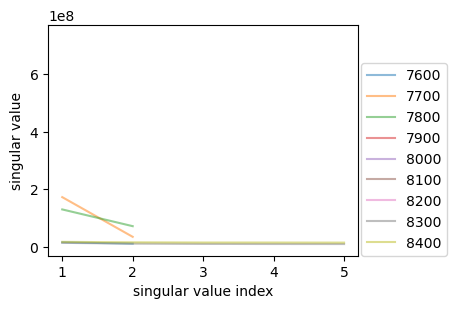

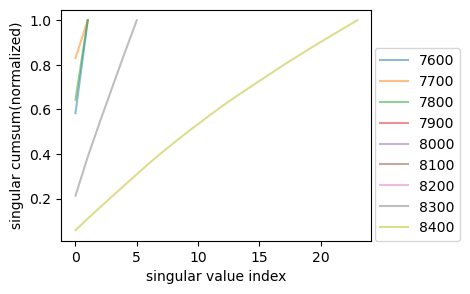

In [3]:
from svd_tool import plot_singular_cum
from svd_tool import plot_gini
test_id = 'long_term_forecast_MSE_loss_iTransformer_cov_Couzin_ft-1_sl25_pl25_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.1_dtTrue_Exp_'
start = 7600
end = 8500
interval = 100
seq_len = 25
gn, gn_std, singular, us, vts, mats, Sigs = plot_singular_cum(test_id, eps=10**7, seed = 1, start=start, end=end, interval=interval, log_bool=False)


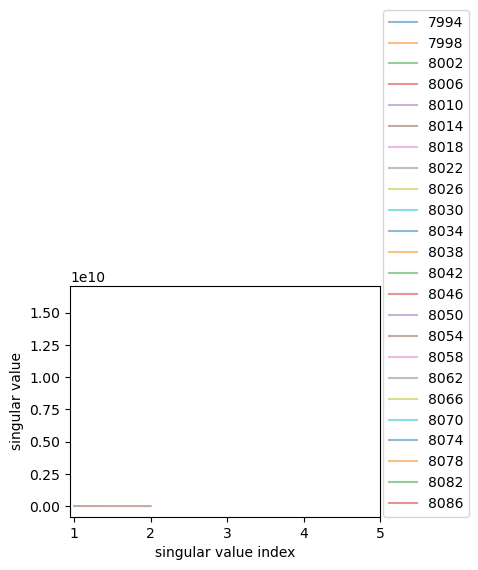

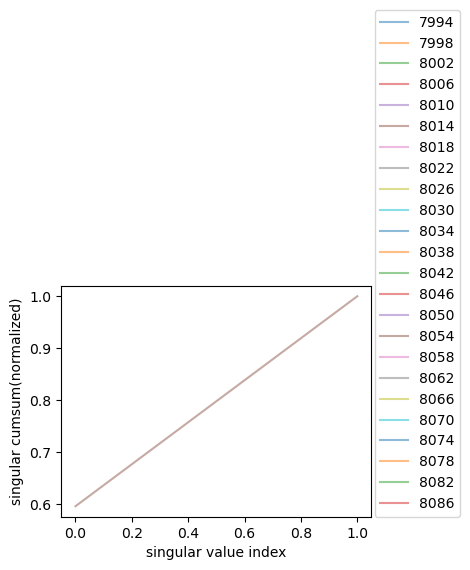

In [1]:
from svd_tool import plot_singular_cum
from svd_tool import plot_gini
test_id = 'long_term_forecast_MSE_loss_iTransformer_cov_Couzin_ft-1_sl25_pl25_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.1_dtTrue_Exp_'
start = 7994
end = 8090
interval = 4
seq_len = 25
gn, gn_std, singular, us, vts, mats, Sigs = plot_singular_cum(test_id, eps=10**7, seed = 1, start=start, end=end, interval=interval, log_bool=False)


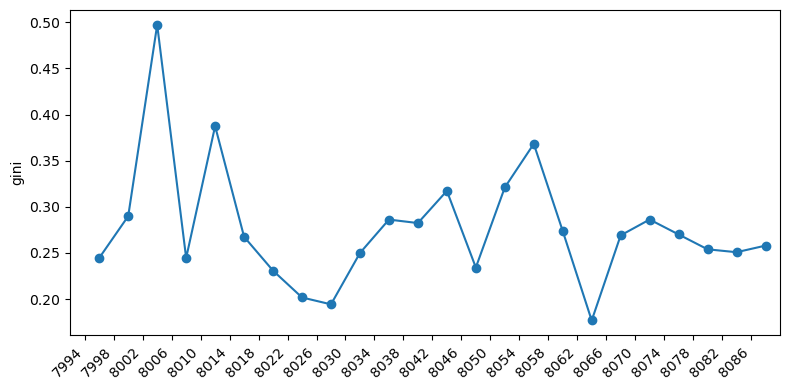

In [7]:
from svd_tool import plot_gini
plot_gini(gn, gn_std)

/home/yuanbing/data/test/ymz_nis/Time-series-forecasting-for-causal-emergence/postprocessing/svd_tool.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,4),dpi=150)


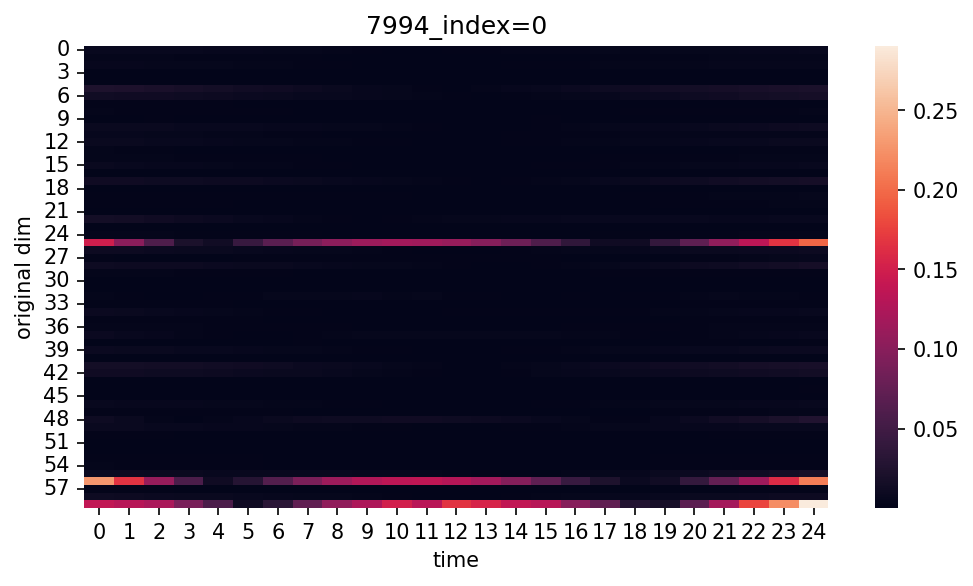

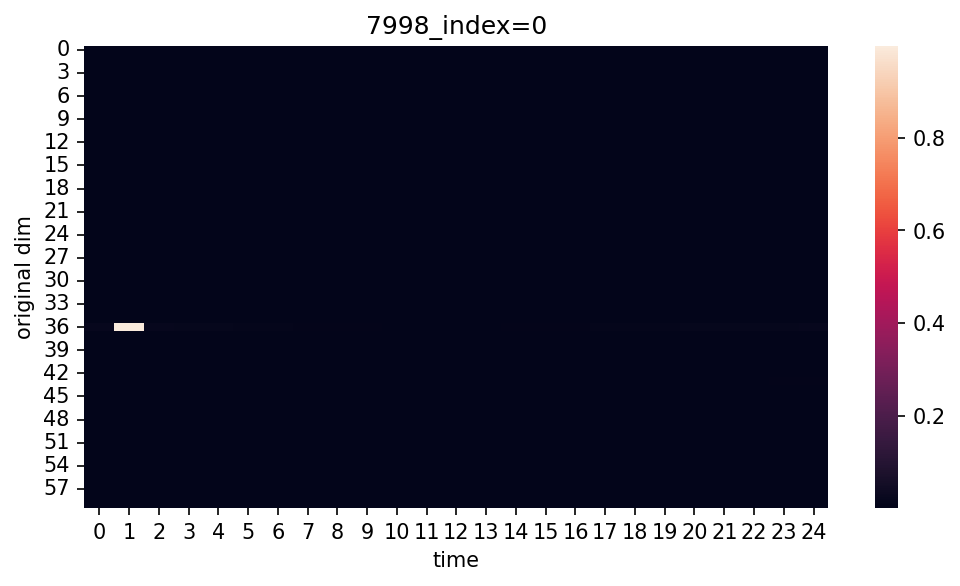

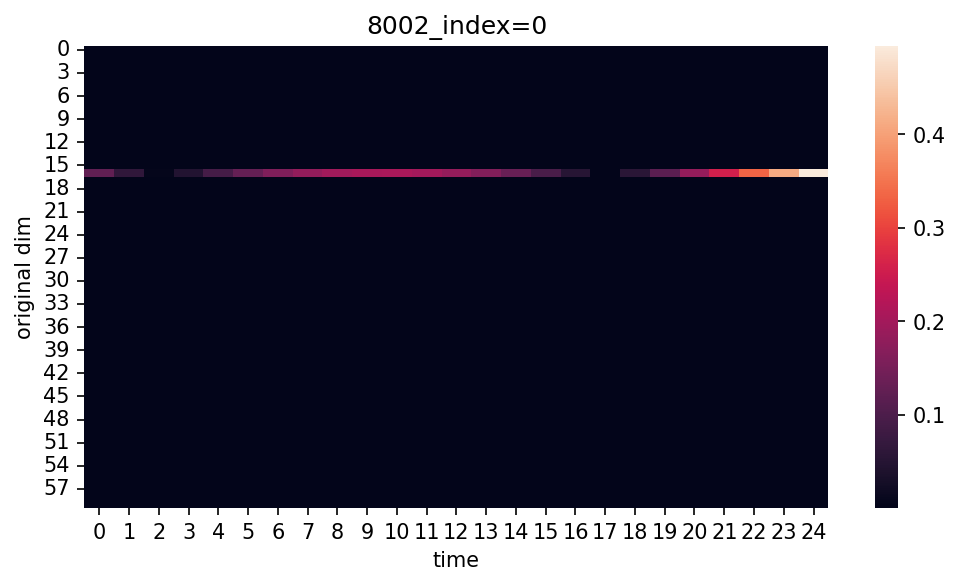

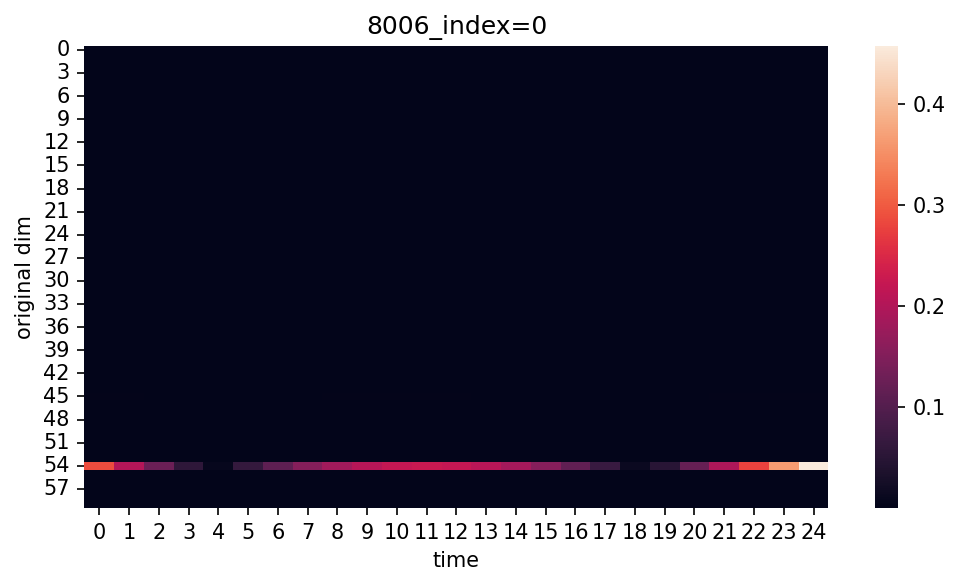

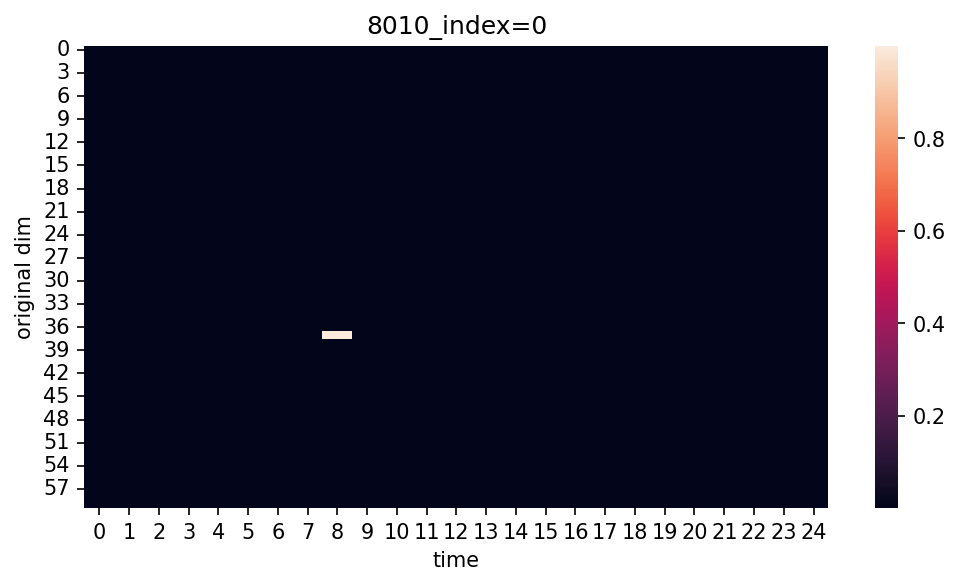

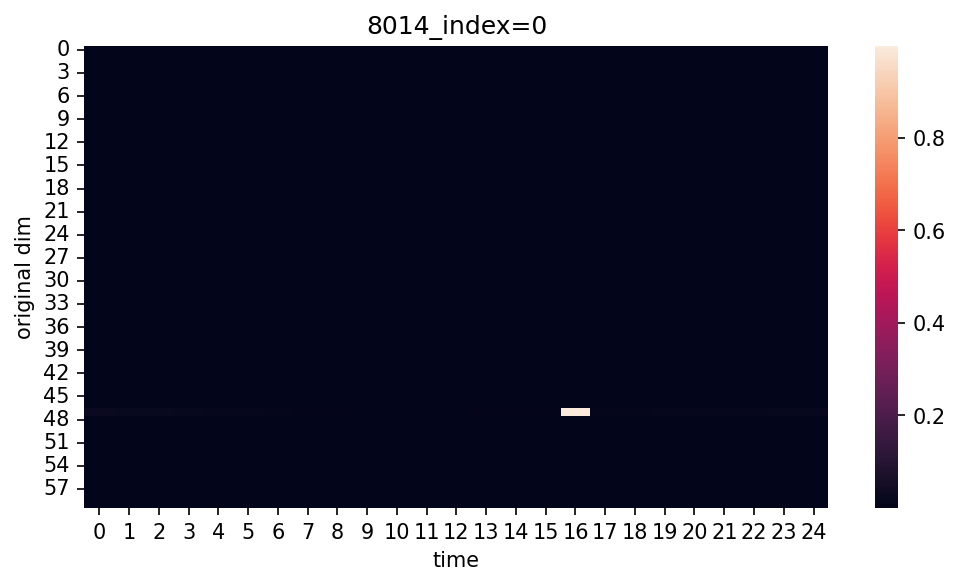

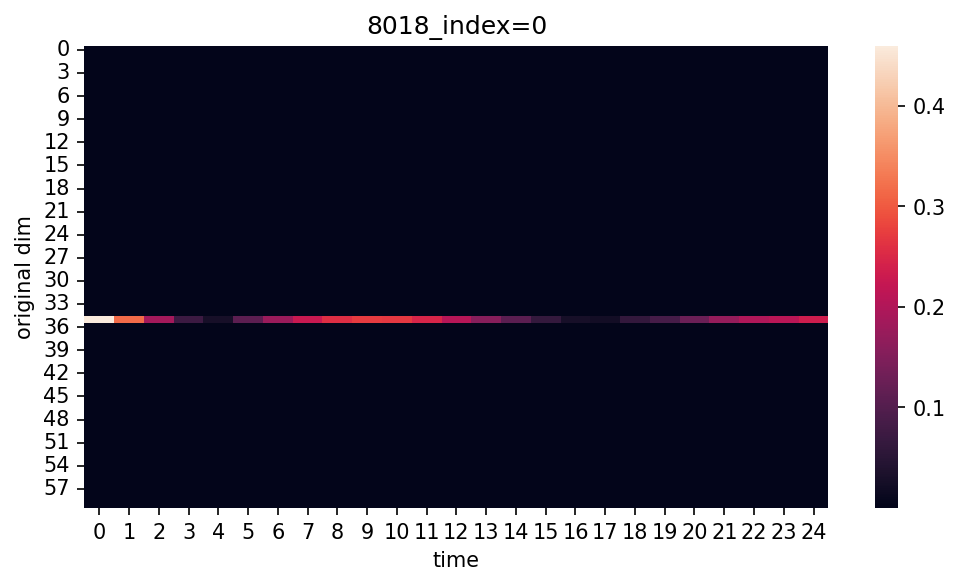

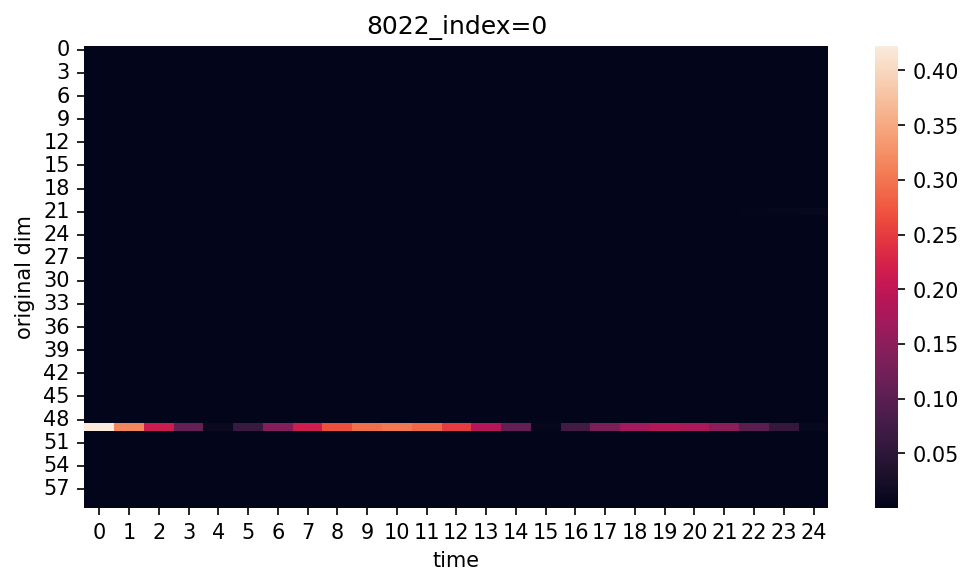

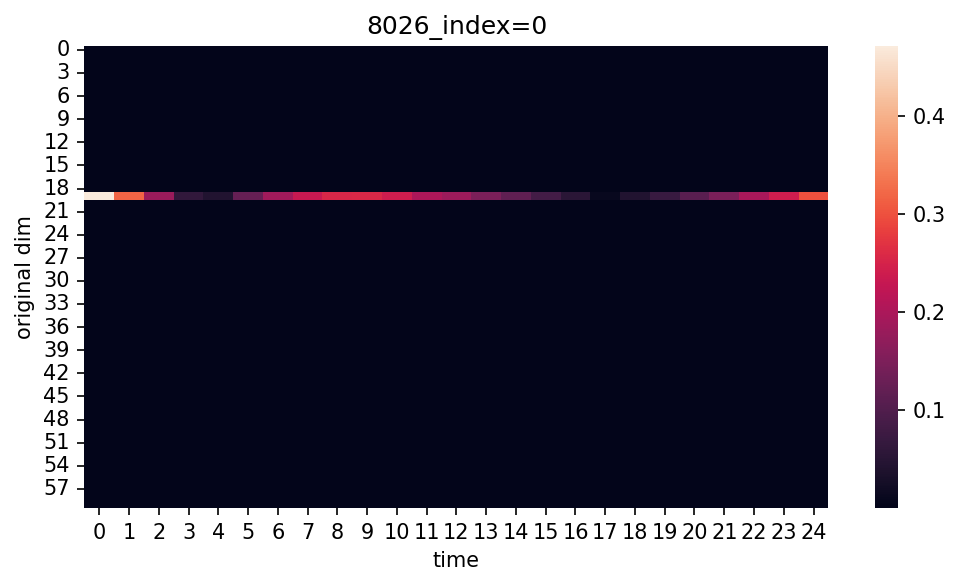

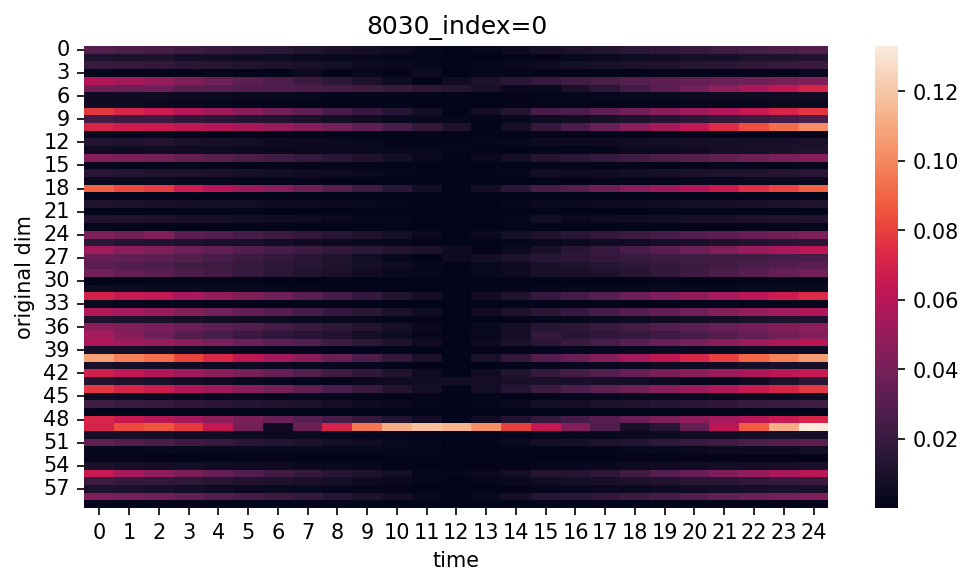

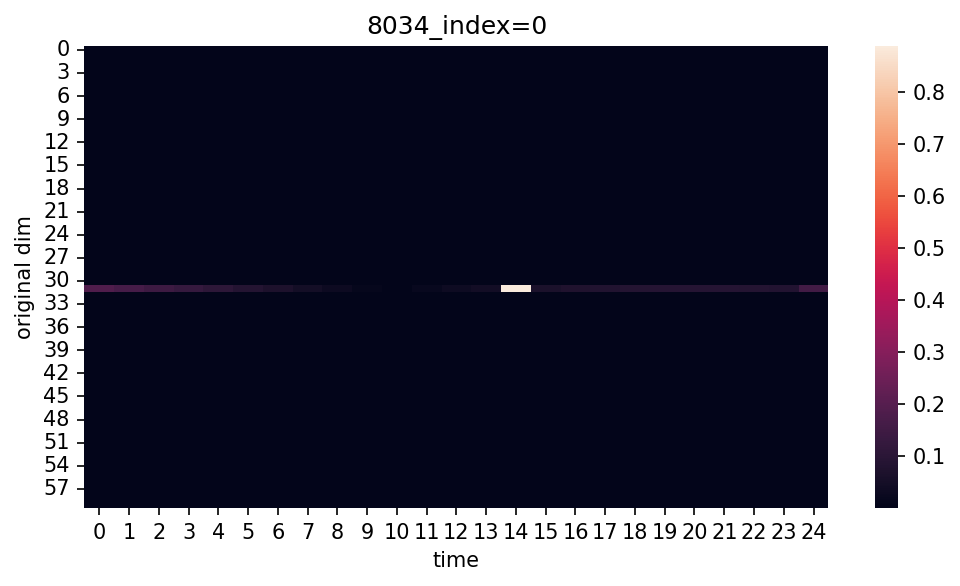

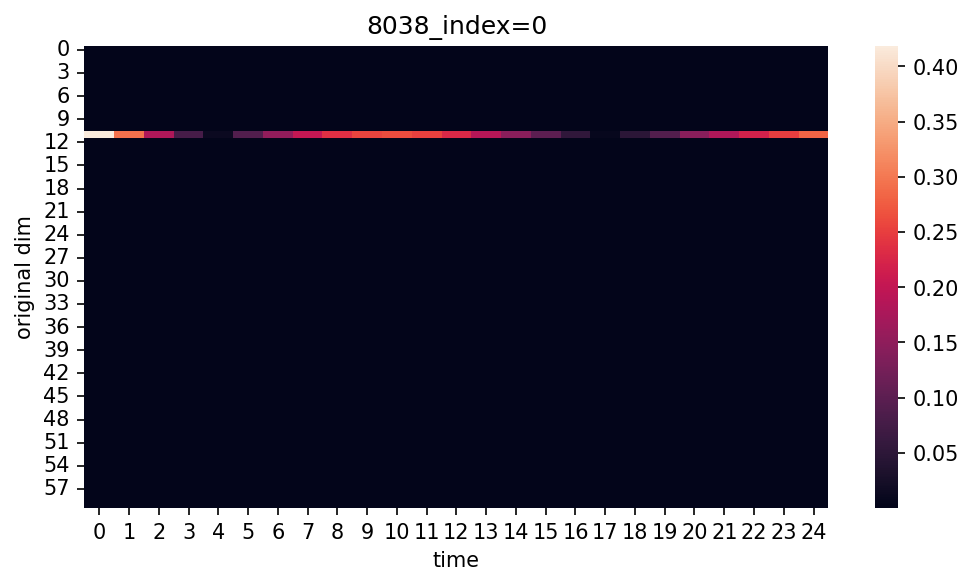

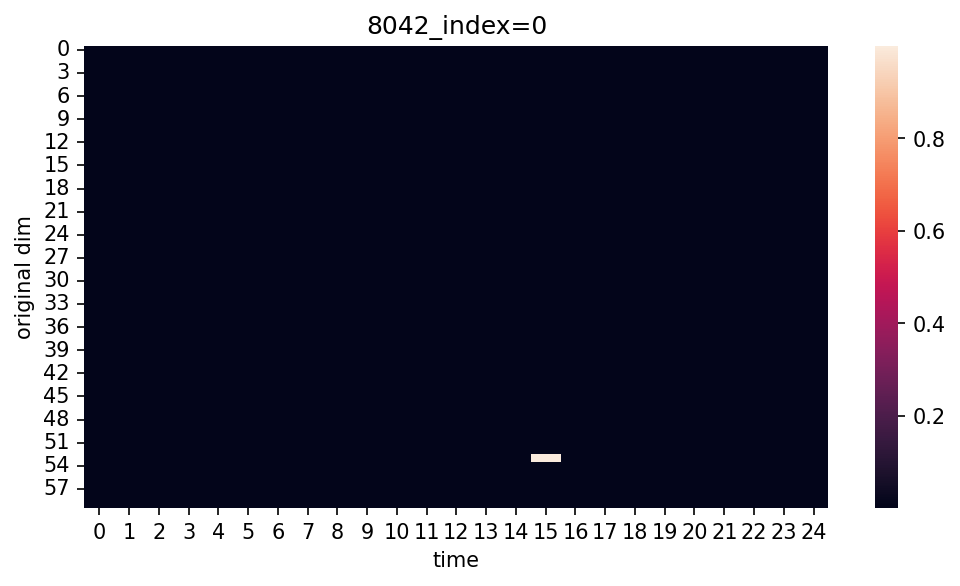

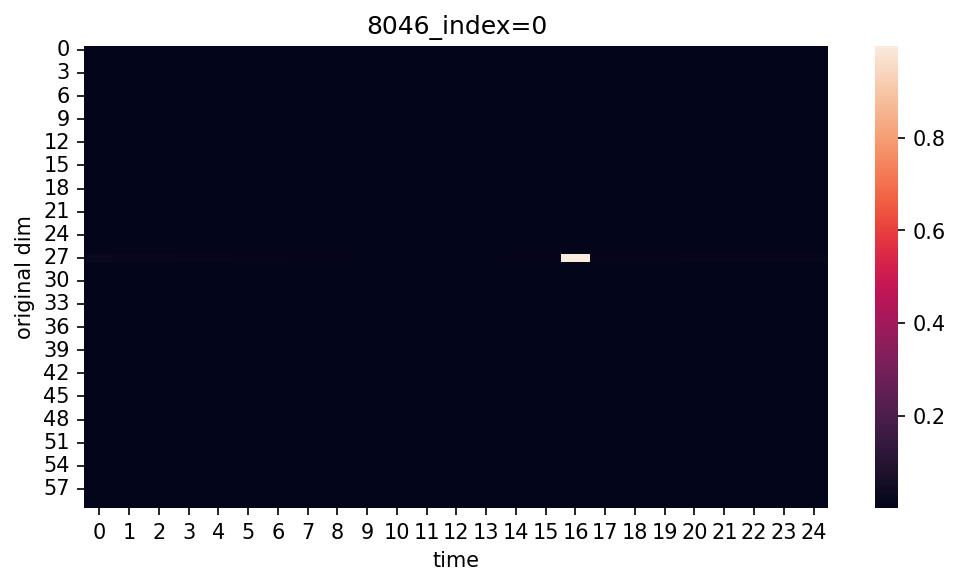

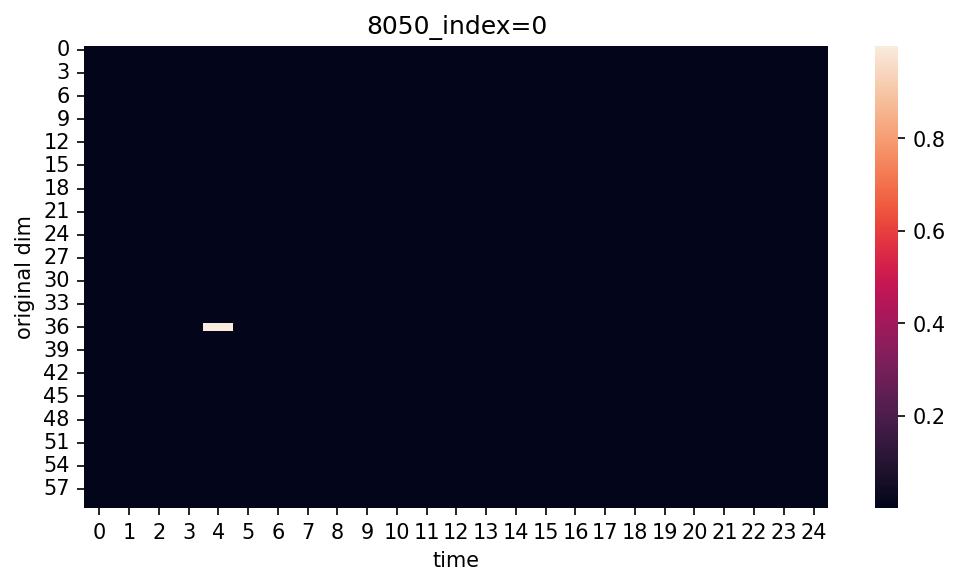

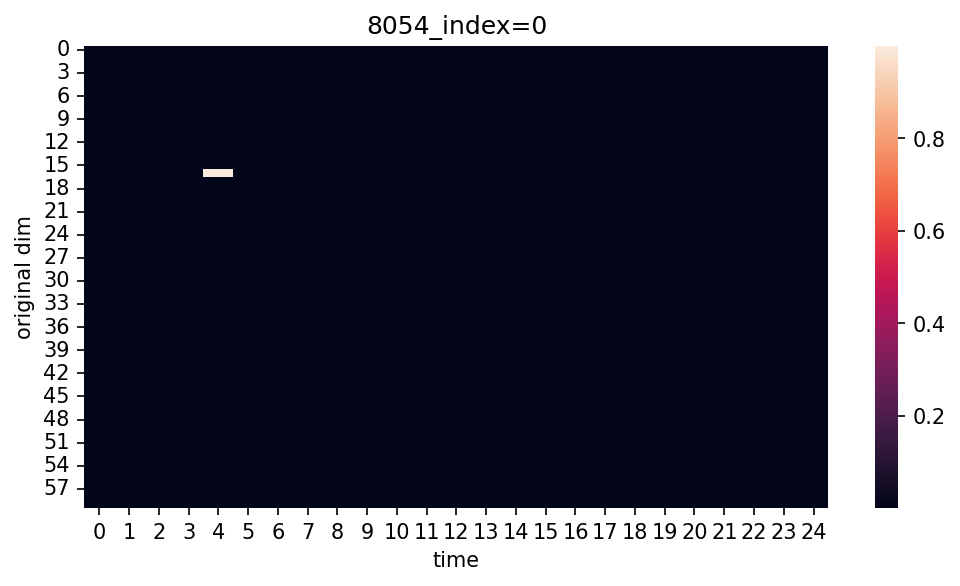

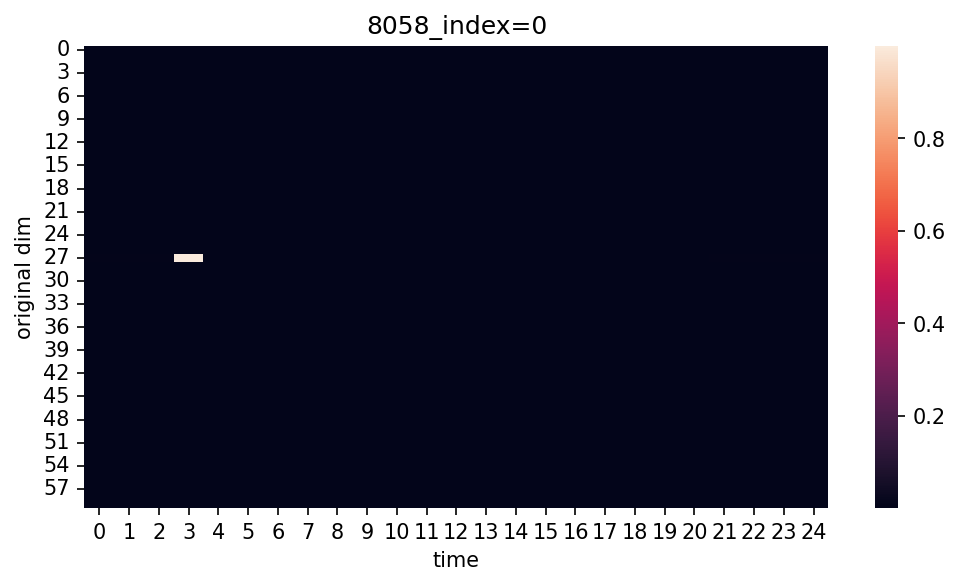

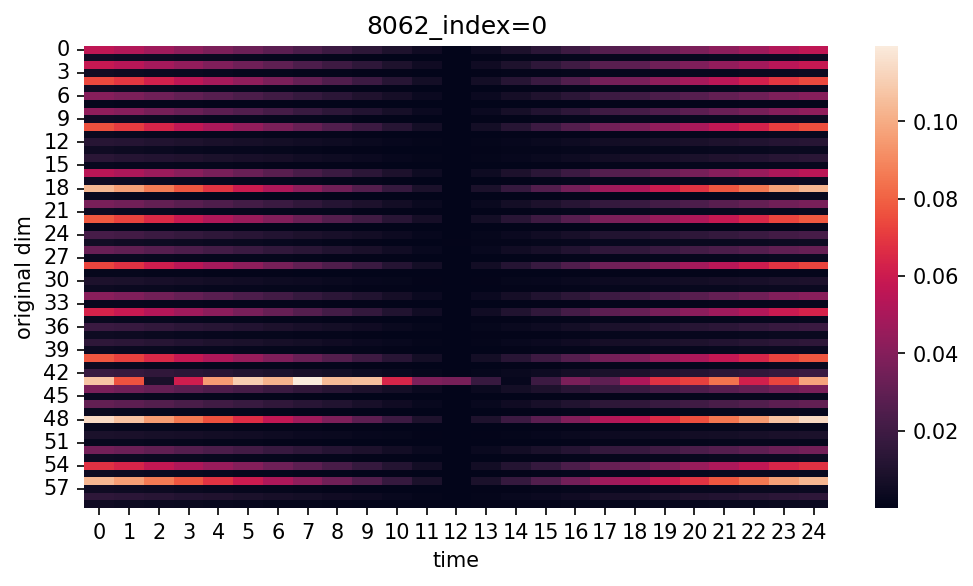

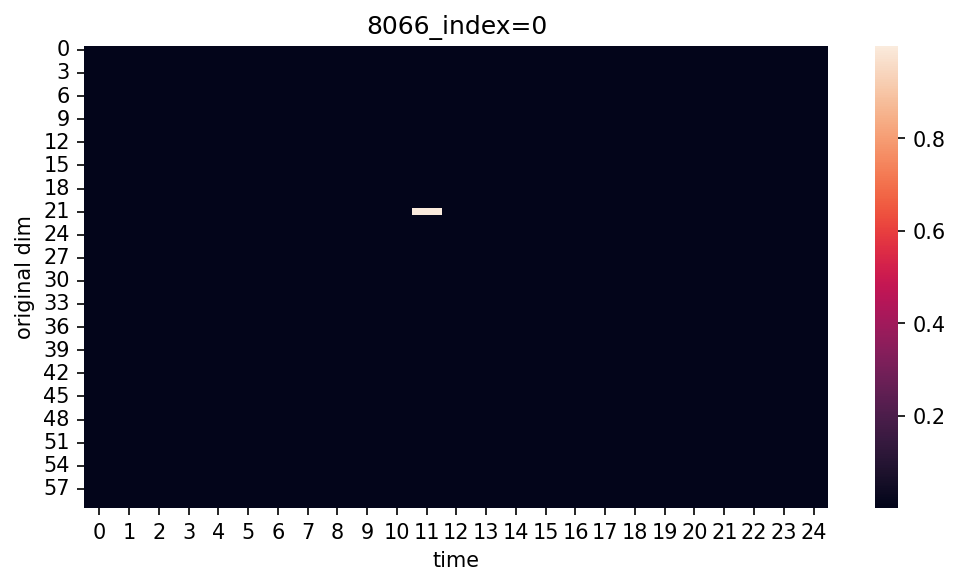

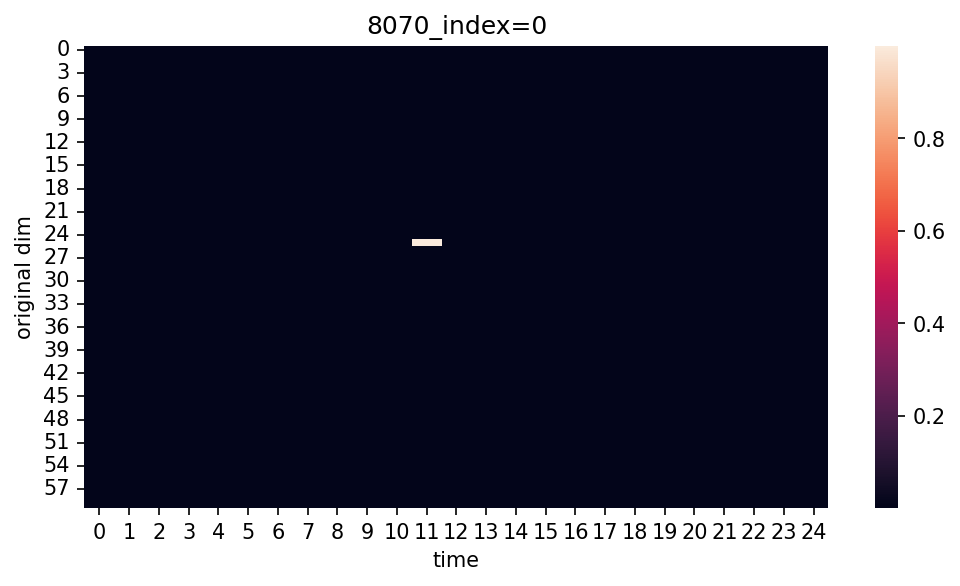

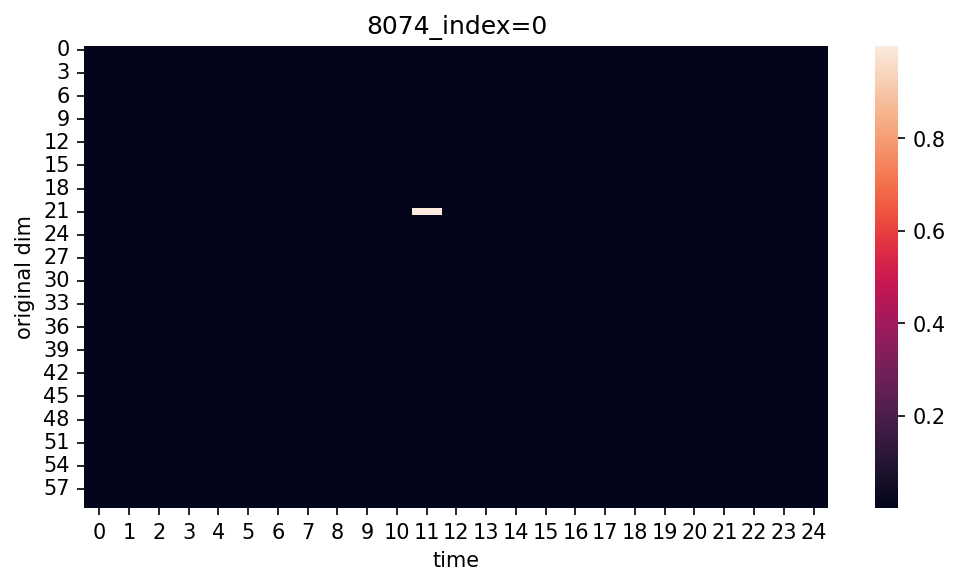

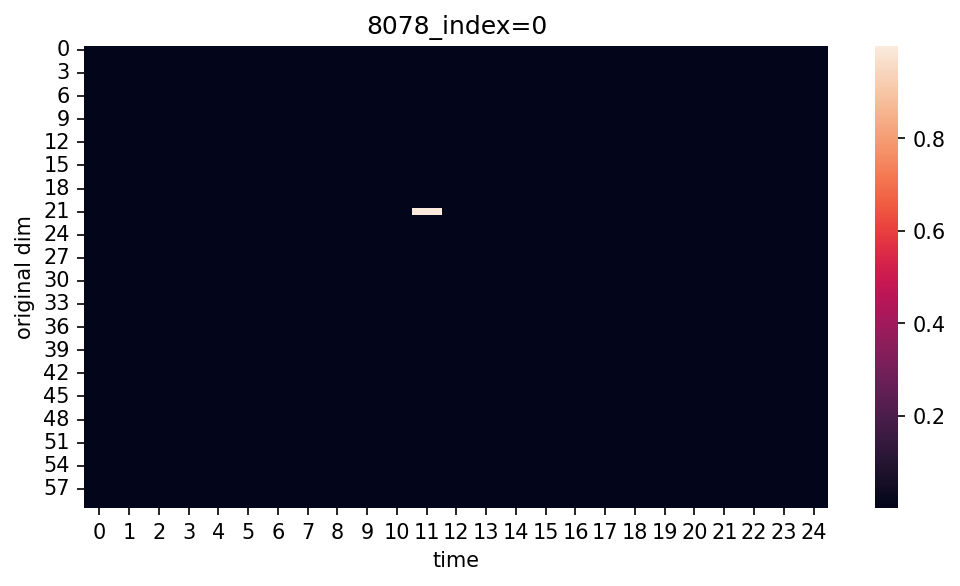

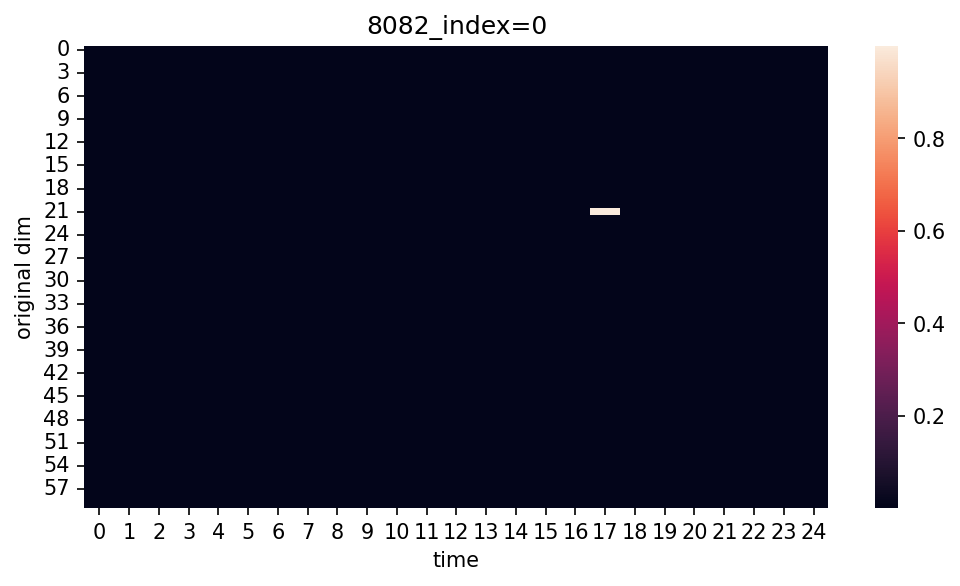

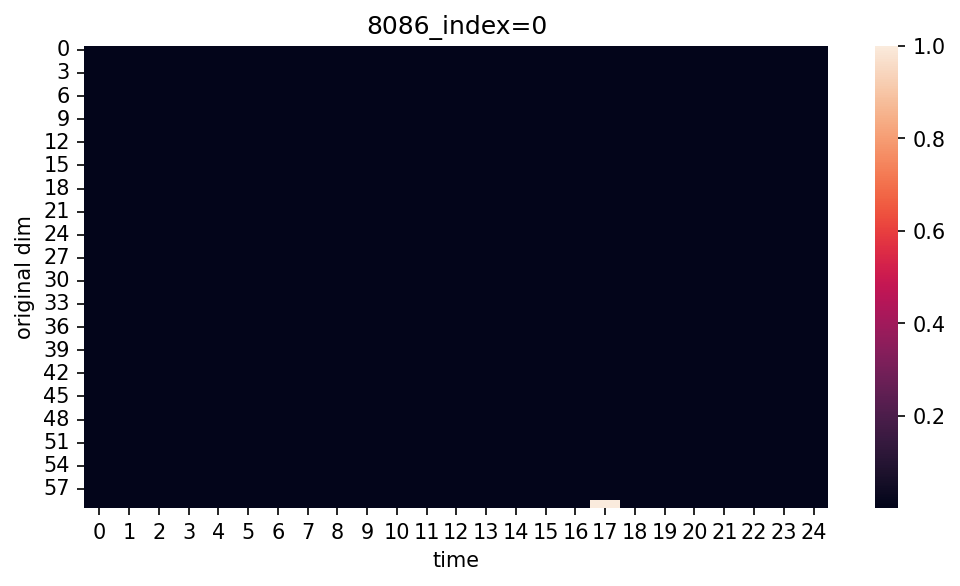

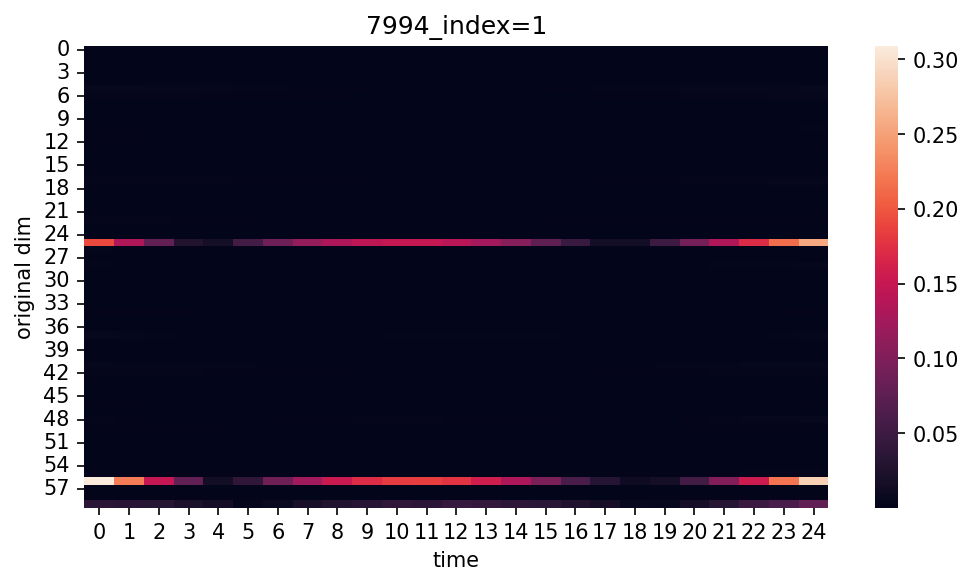

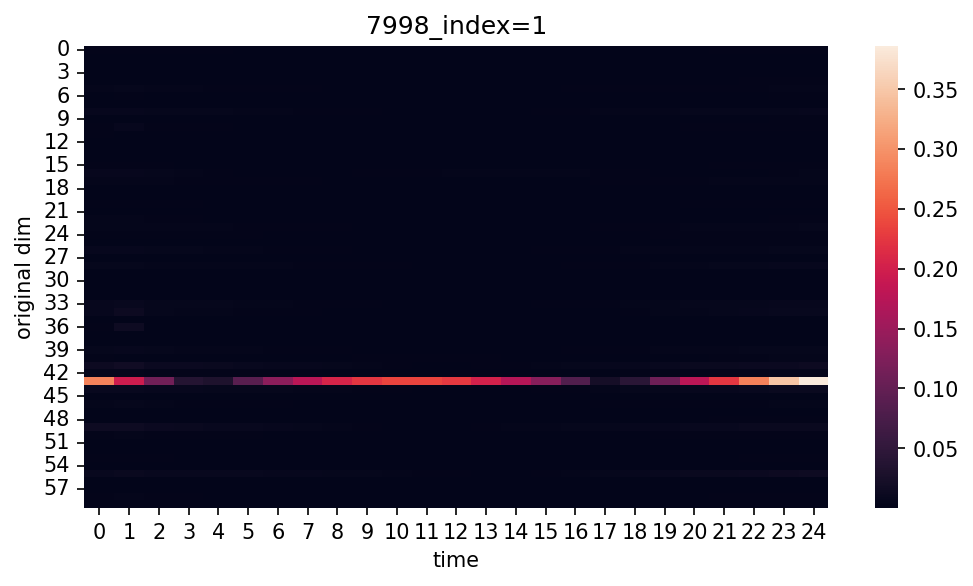

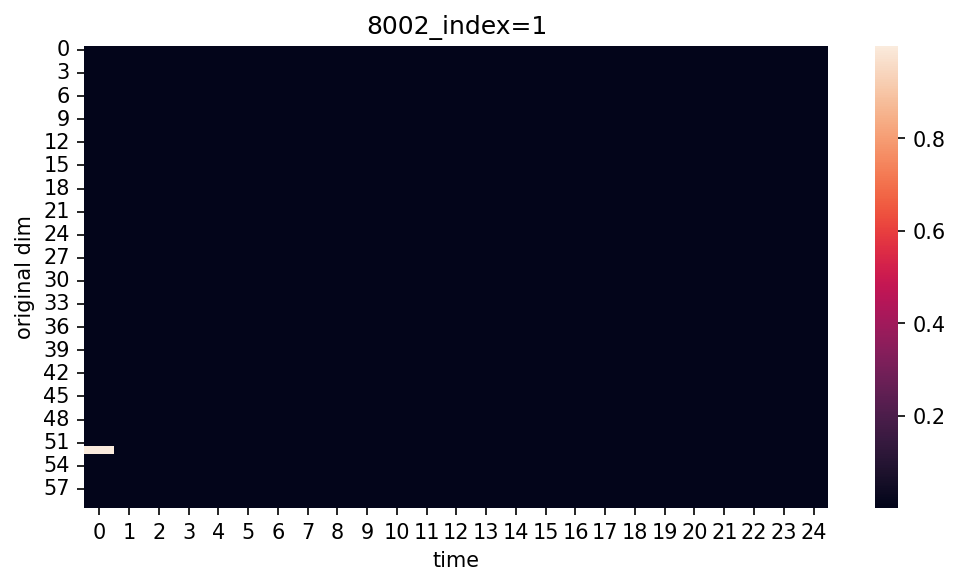

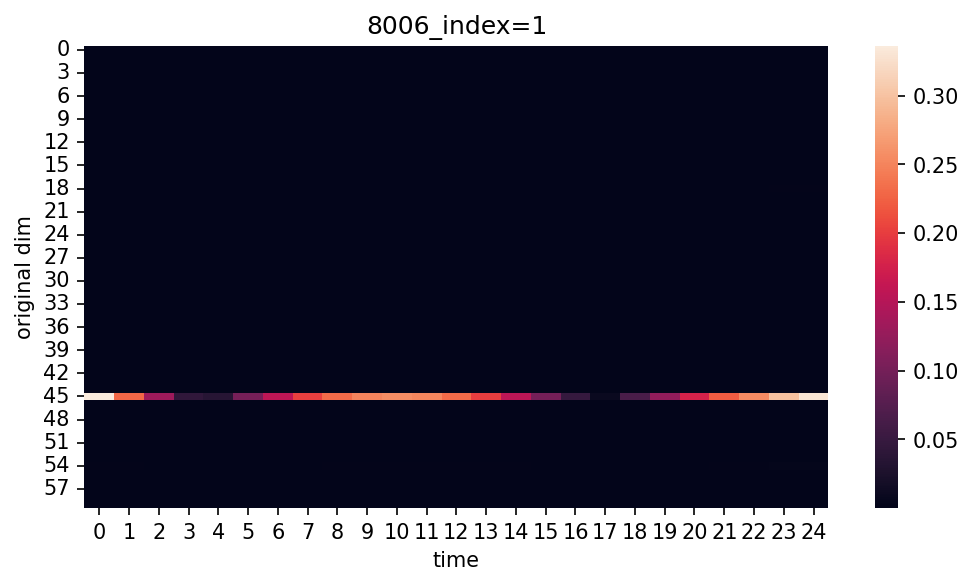

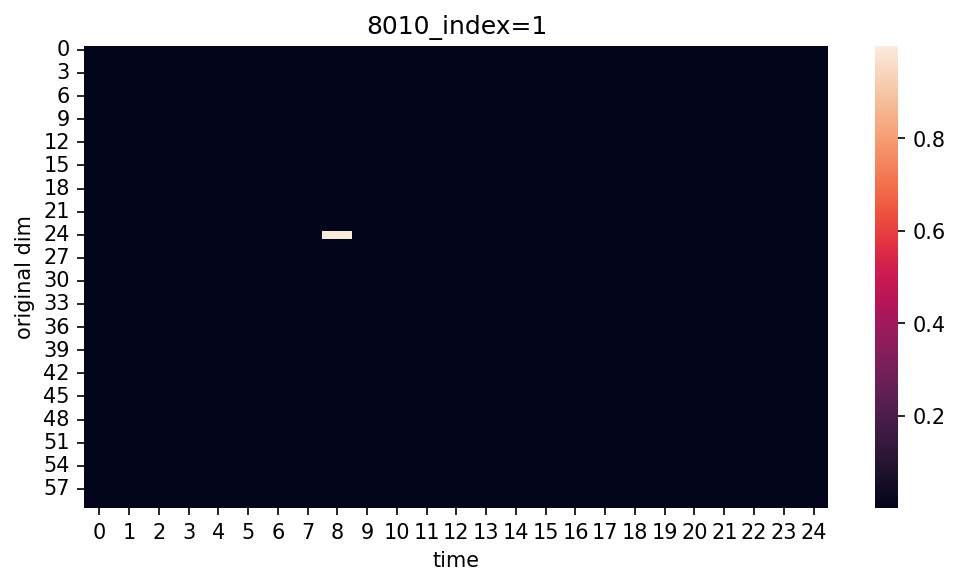

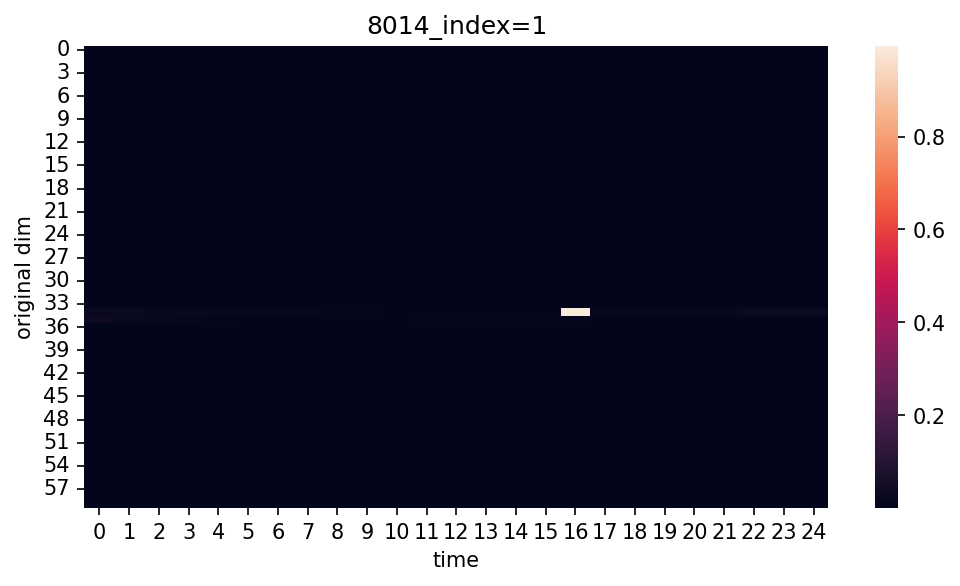

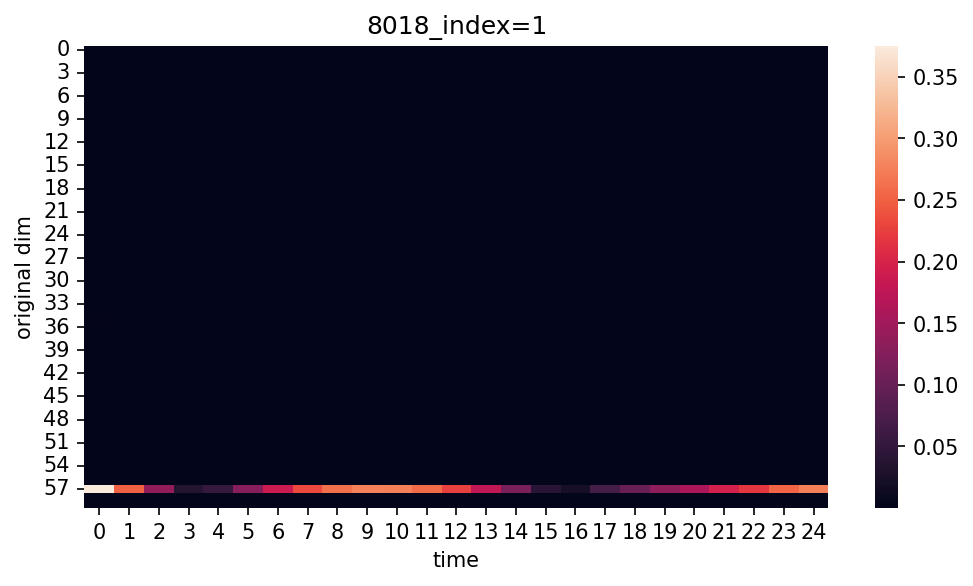

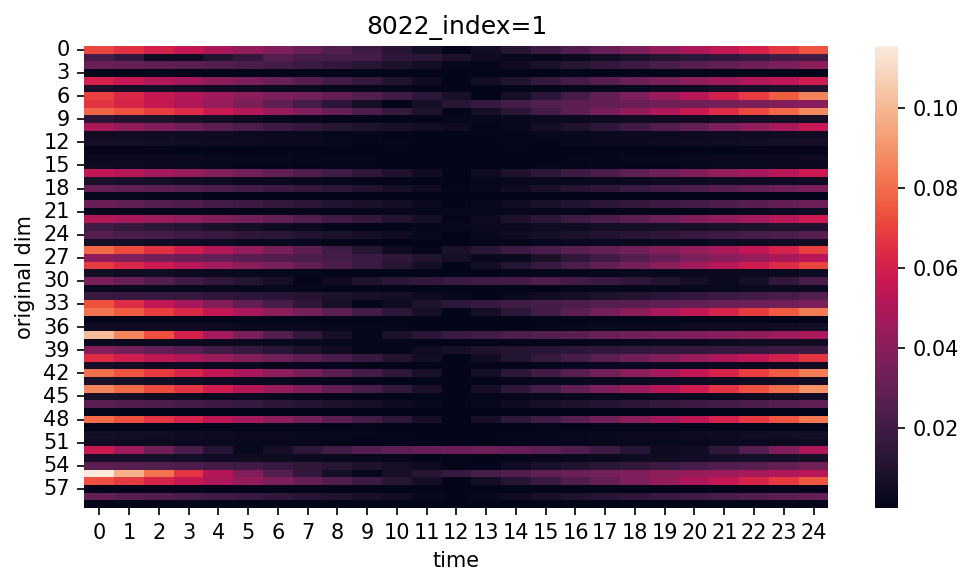

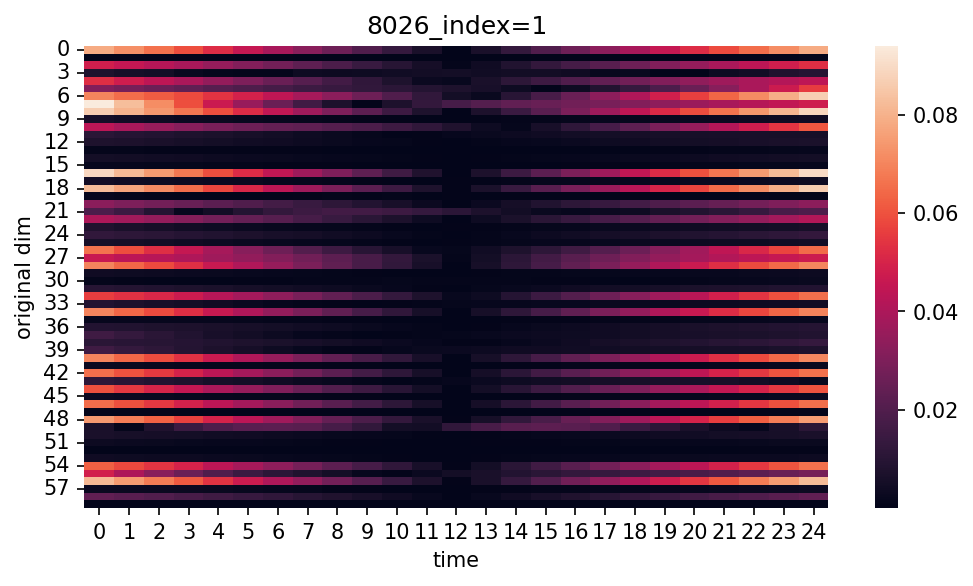

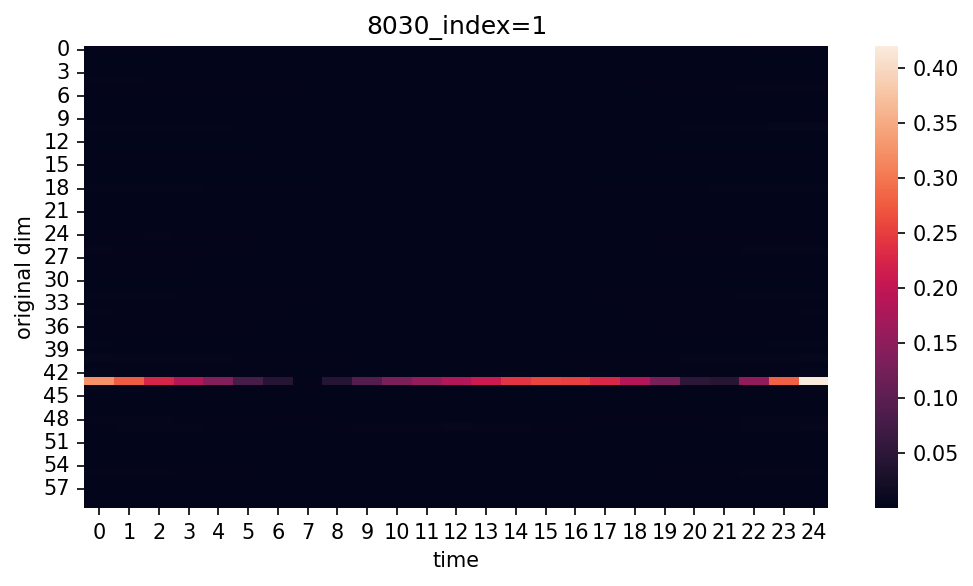

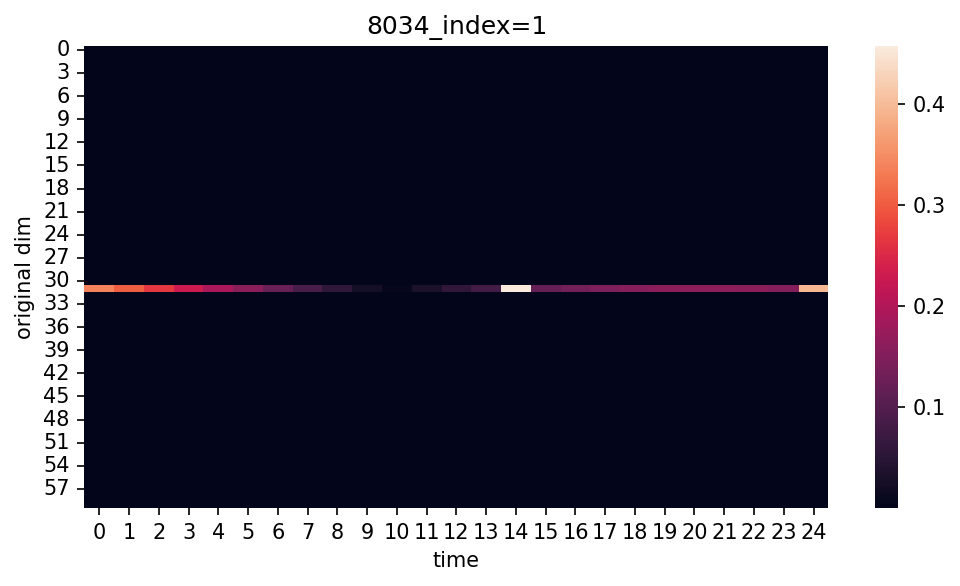

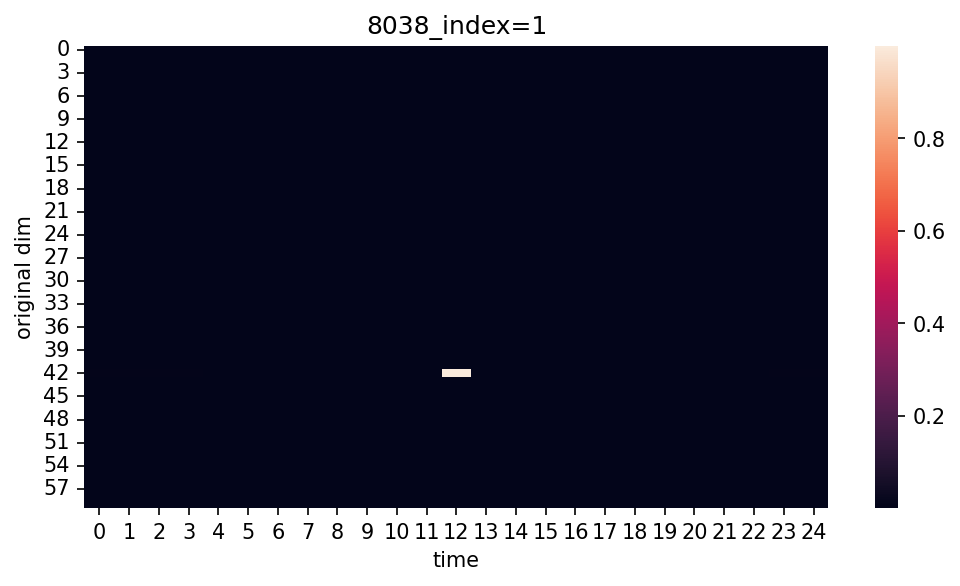

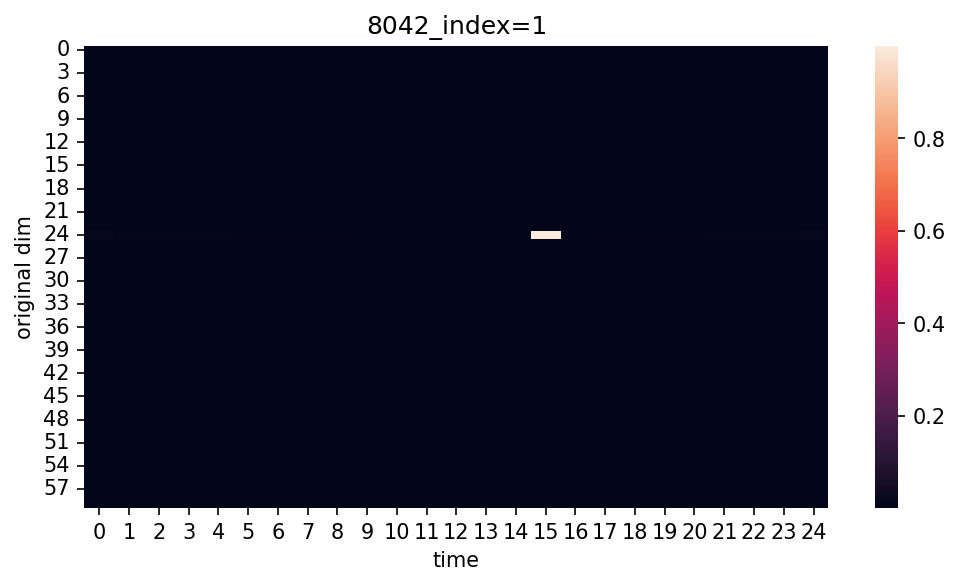

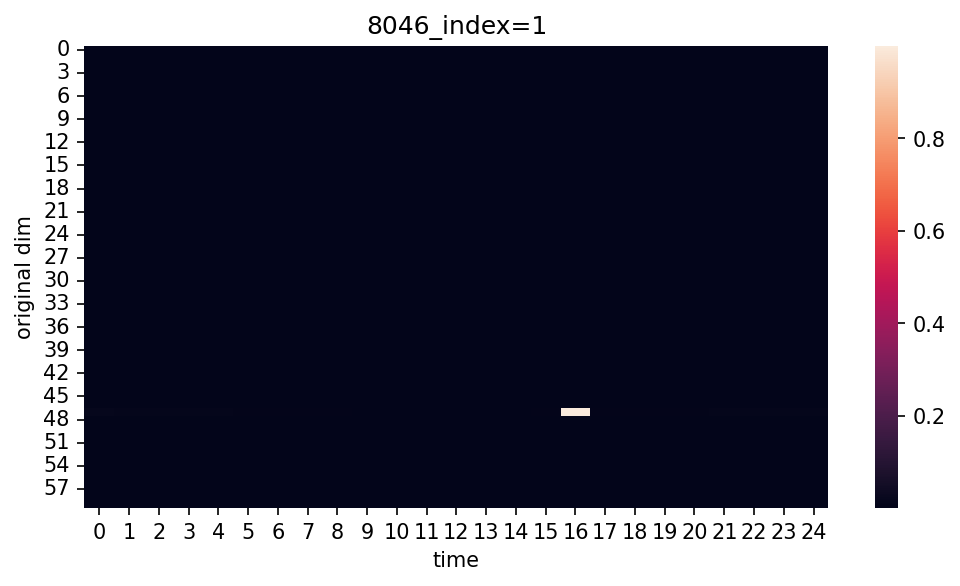

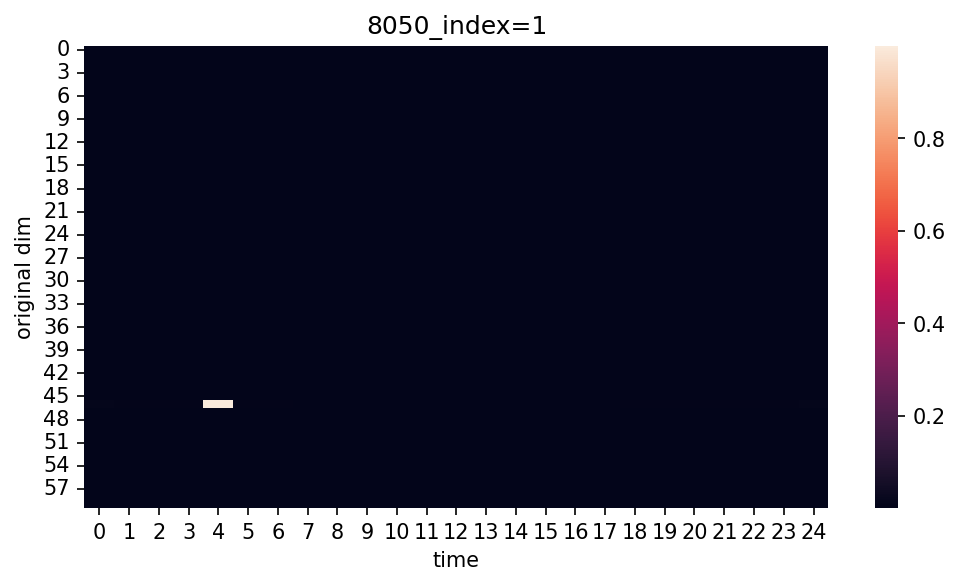

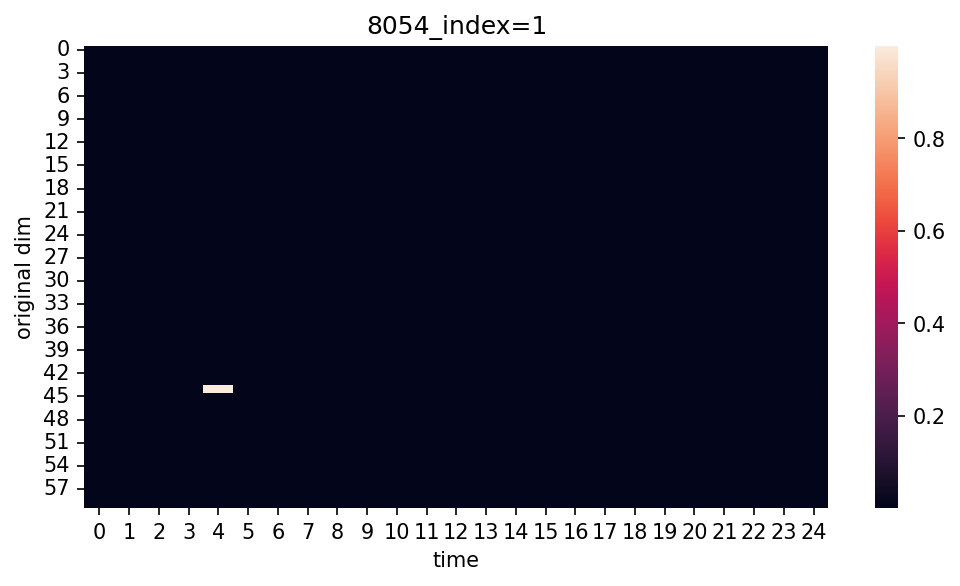

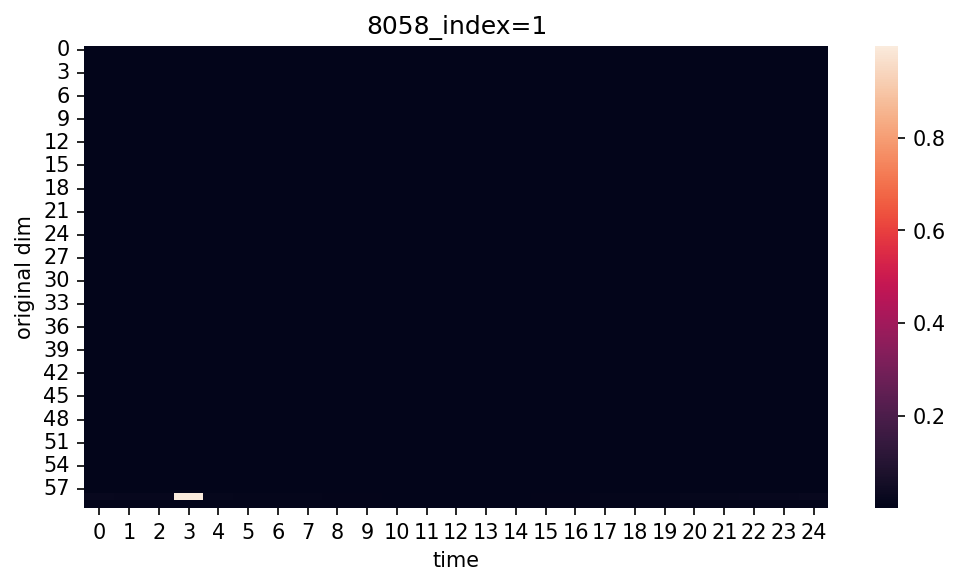

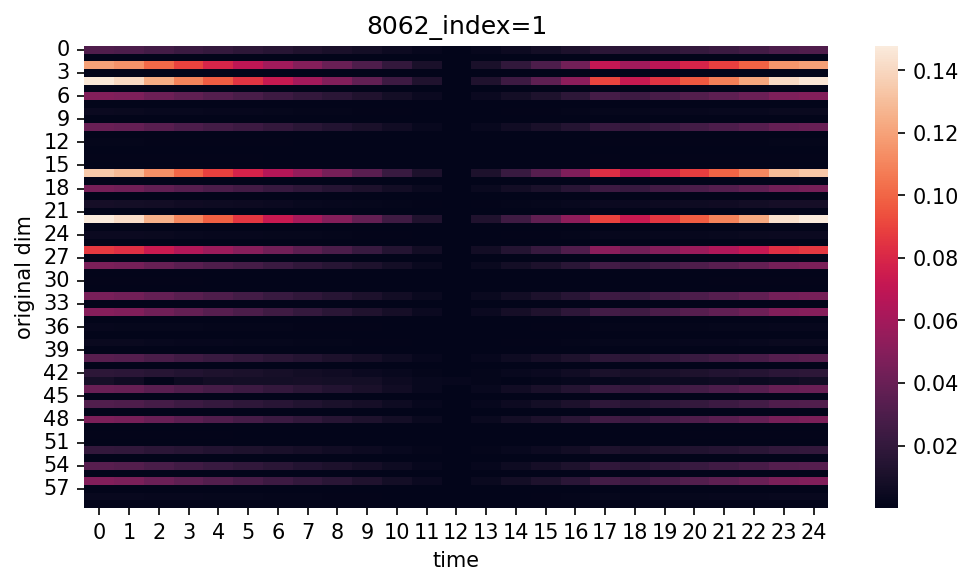

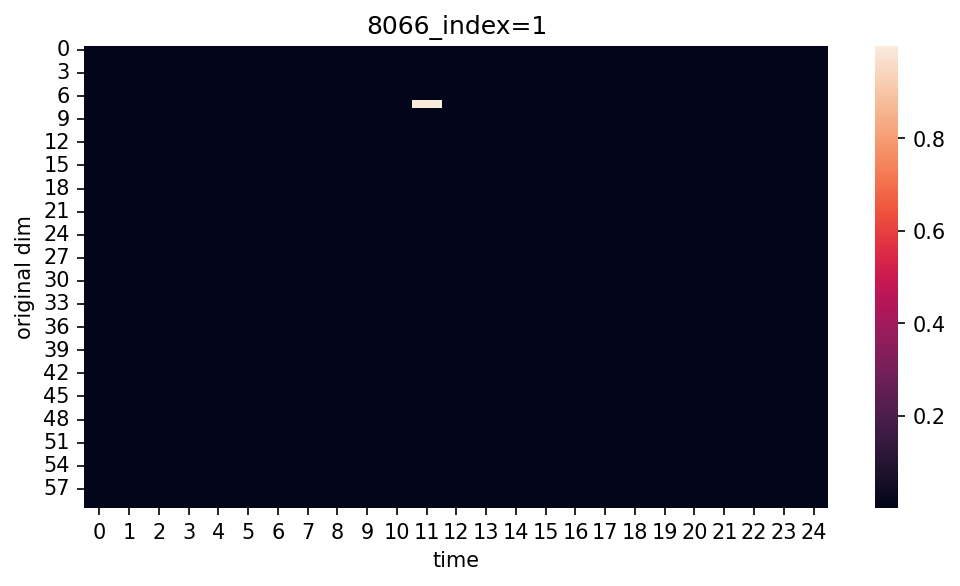

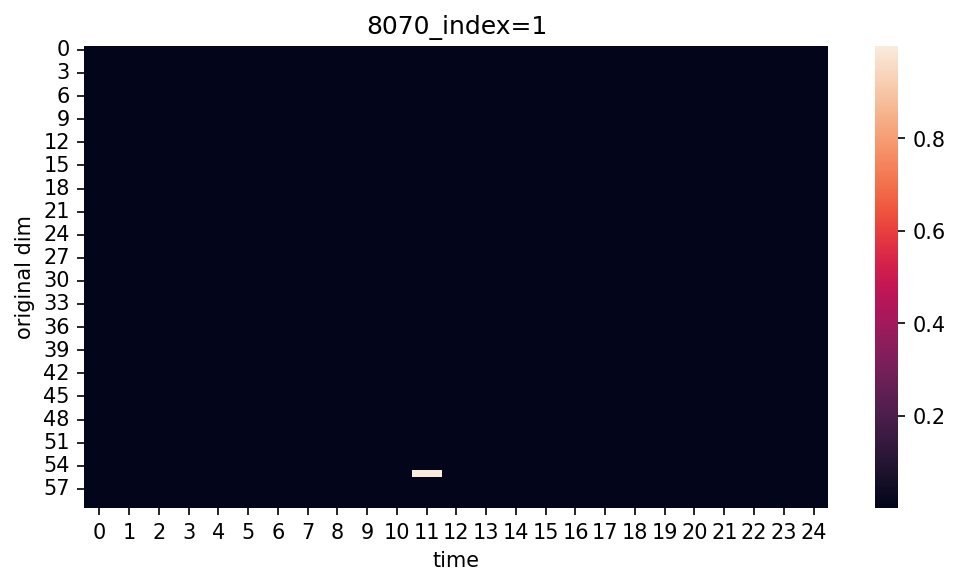

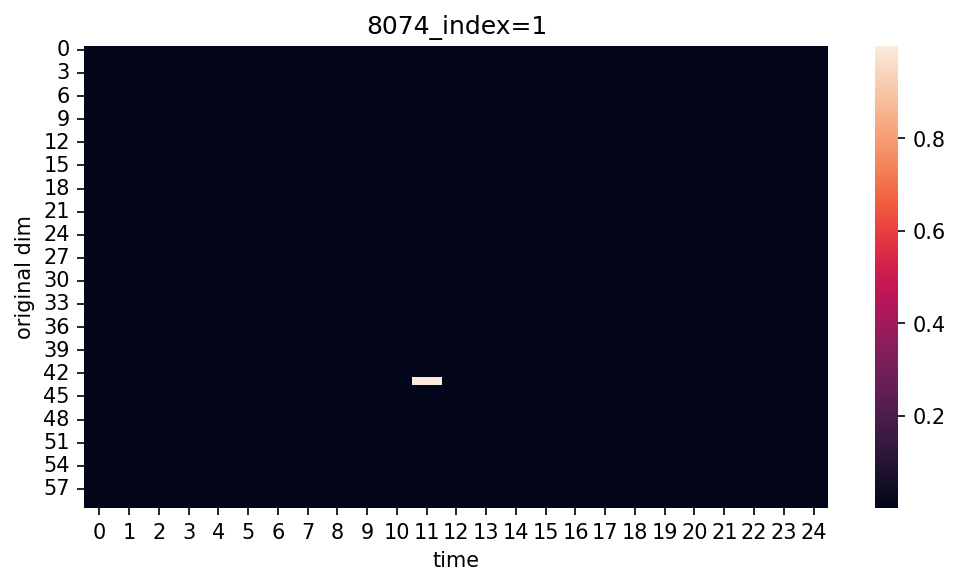

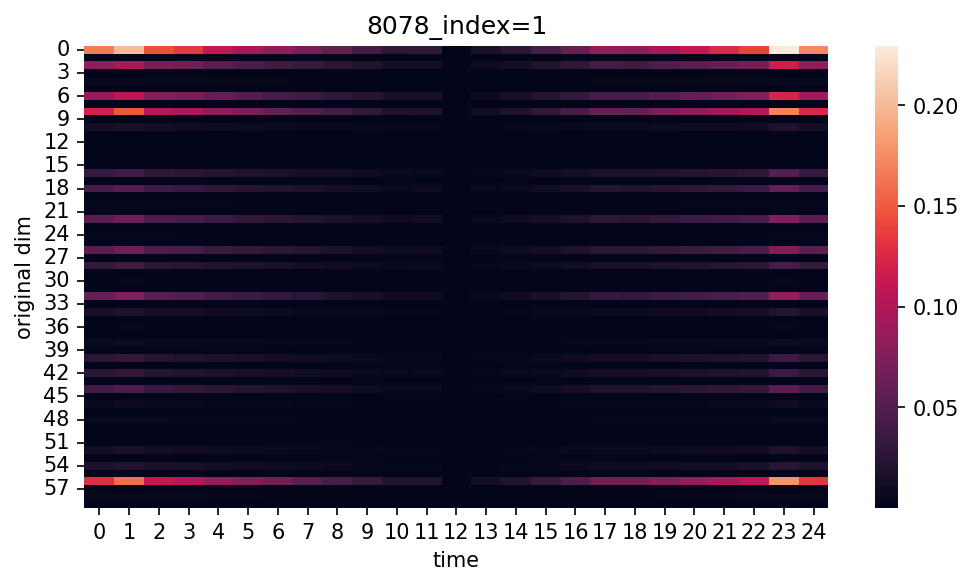

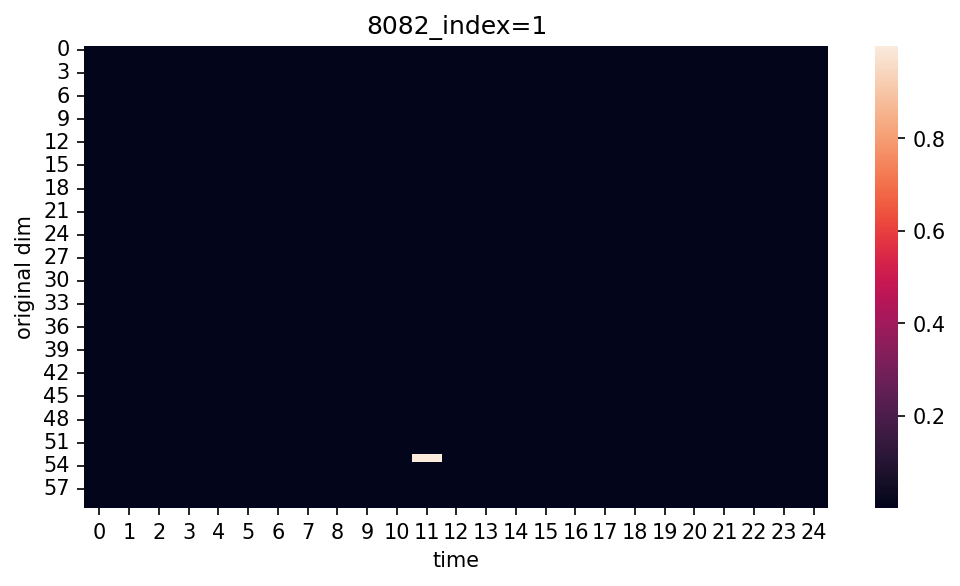

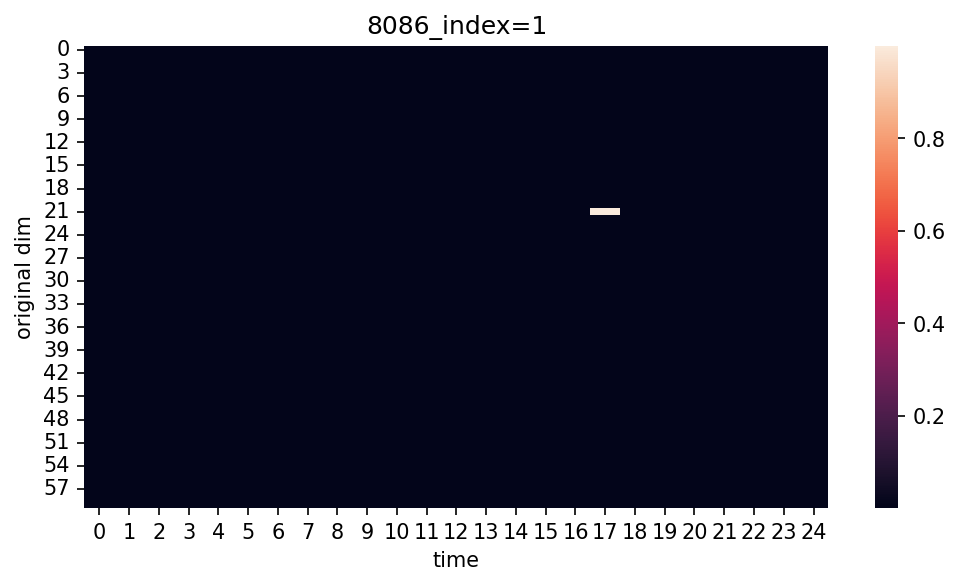

In [8]:
from svd_tool import analysis_u
analysis_u(us, seq_len=25, dims=60, start=start, end=end, interval=interval, target=[0,1])

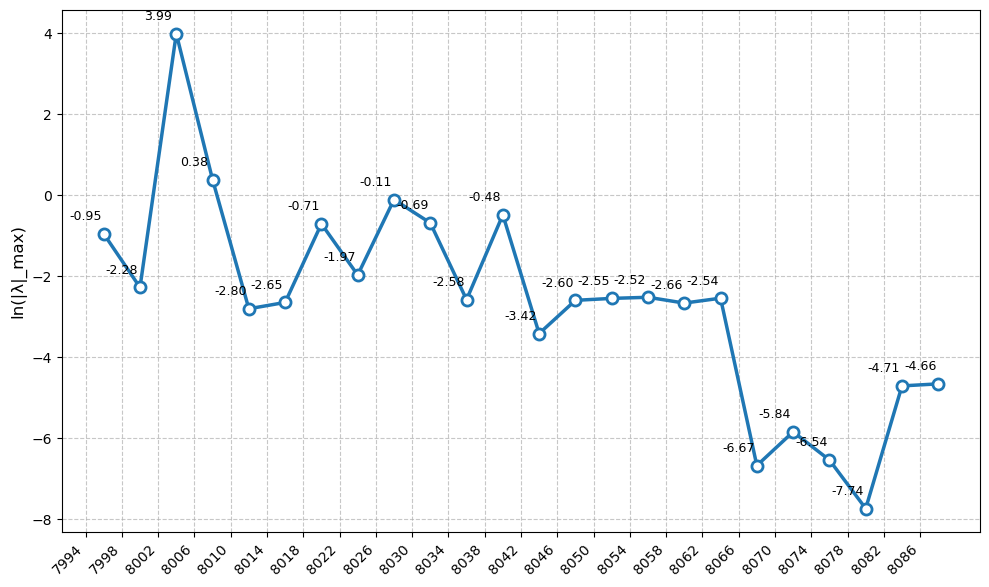

In [2]:
from svd_tool import macro_analysis
macro_analysis(us, mats, start, end, interval)

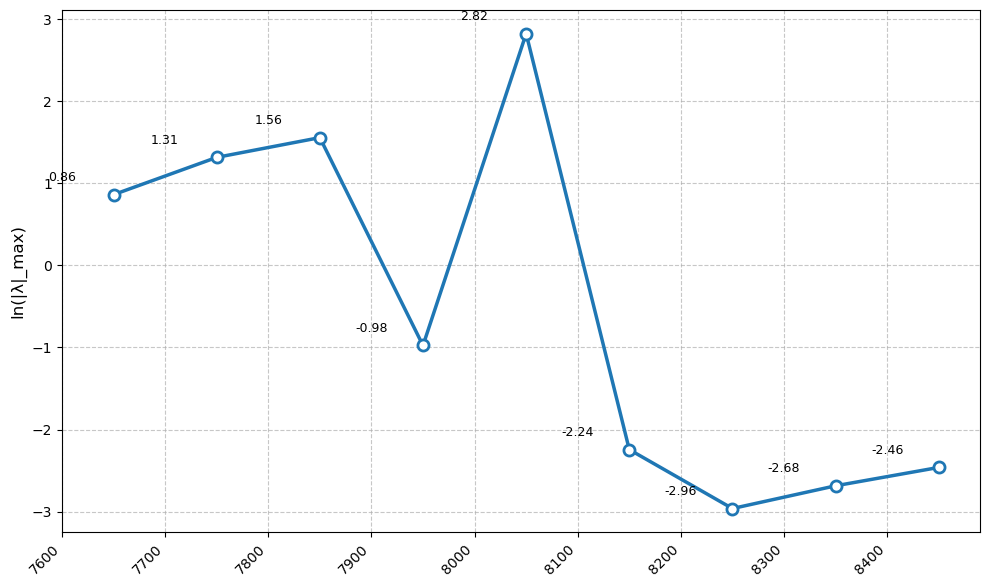

In [4]:
from svd_tool import macro_analysis
start = 7600
end = 8500
interval = 100
macro_analysis(us, mats, start, end, interval)